In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
import statsmodels.api as sm
import matplotx
plt.style.use(matplotx.styles.aura['dark'])

In [2]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i+1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )
def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w
colors = ['tab:red', 'tab:blue']

In [3]:
with open('test_data_acc_ind_492_0607.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())
n_neurons = len(data['spikes'])
print(f'n_neurons: {n_neurons}')


dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324


In [4]:
x = data['choice'][data['laserON']==0]
x.sum()/x.shape

array([0.54307116])

trial lengths = 11.529320000000098


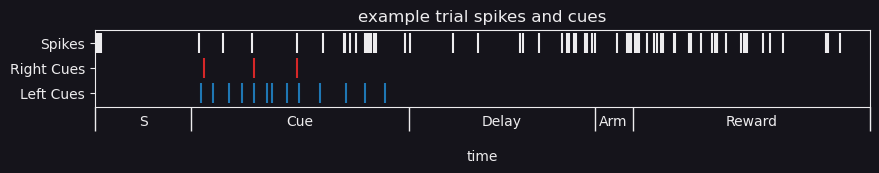

In [5]:
neuron = 10
trial_idx = np.nonzero(data["currMaze"] > 7)[0][18]
trial_start = data["trialStart"][trial_idx]
trial_end = data["trialEnd"][trial_idx]
trial_length = trial_end - trial_start
spikes = data["spikes"][neuron]
spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
keyframes = data["keyFrames"][trial_idx]
keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
lcue_times = data['cueOnset_L'][trial_idx]
rcue_times = data['cueOnset_R'][trial_idx]
fig, ax = plt.subplots(figsize=(10, 1))
ax.vlines(spikes - trial_start, 2.1, 2.9)
ax.vlines(lcue_times, 0.1, 0.9, colors='tab:blue')
ax.vlines(rcue_times, 1.1, 1.9, colors='tab:red')
ax.set_yticks(np.arange(0.5, 3, 1))
ax.set_yticklabels(['Left Cues', 'Right Cues', 'Spikes'])
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_xlim([0, trial_length])
ax.set_title("example trial spikes and cues")
ax.set_xlabel("time")
print(f'trial lengths = {trial_end - trial_start}')


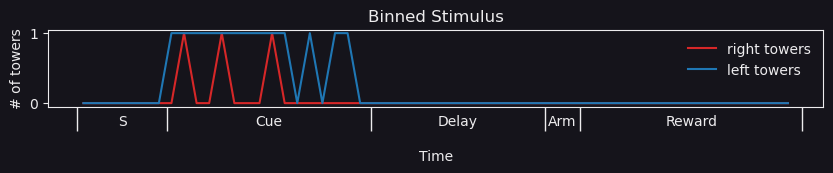

In [6]:
bins = np.arange(0, trial_length, 0.2)
bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

fig, ax = plt.subplots(figsize=(10, 1))
binned_stimr, _ = np.histogram(rcue_times, bins)
plt.plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
binned_stiml, _ = np.histogram(lcue_times, bins)
plt.plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_ylabel("# of towers")
ax.set_title("Binned Stimulus")
ax.legend()


Text(0.5, 1.0, 'Binned Spikes')

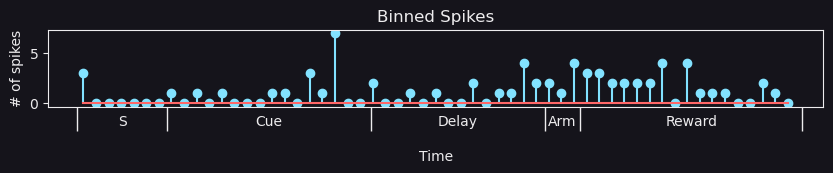

In [7]:
fig, ax = plt.subplots(figsize=(10, 1))
binned_spikes, _ = np.histogram(spikes-trial_start, bins)
plt.stem(bin_centers, binned_spikes, label="spikes")
trial_xticks(ax, xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
ax.set_ylabel("# of spikes")
ax.set_title("Binned Spikes")


(57, 10)

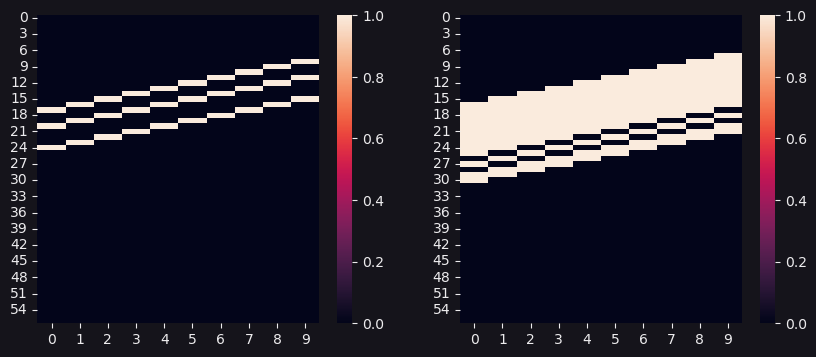

In [8]:
filt_len = 10
padded_stimr = np.pad(binned_stimr, (filt_len-1, 0), constant_values=(0, 0))
X_sr = hankel(padded_stimr[:-filt_len+1], padded_stimr[-filt_len:])
padded_stiml = np.pad(binned_stiml, (filt_len-1, 0), constant_values=(0, 0))
X_sl = hankel(padded_stiml[:-filt_len+1], padded_stiml[-filt_len:])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(X_sr, ax=axs[0])
sns.heatmap(X_sl, ax=axs[1])
X_sr.shape

(57, 10)

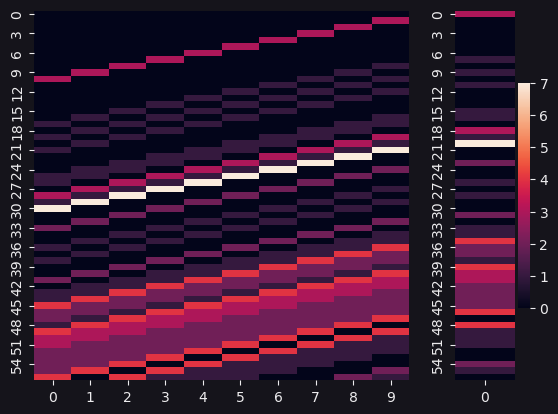

In [9]:
padded_spikes = np.pad(binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0))
X_sp = hankel(padded_spikes[:-filt_len+1], padded_spikes[-filt_len:])
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]})
sns.heatmap(X_sp, ax=axs[0], cbar=False)
sns.heatmap(binned_spikes[:, np.newaxis], ax=axs[1])
X_sp.shape

# Fitting poisson glm to single neuron on all trials

In [64]:
# constructing design matrix with all trials

neuron = 277
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f'number of trials: {trial_indices.size}')
X = []
y = []
filt_len = 30
sp_filt_len = 30
bin_size = 0.35
trial_id = []

for trial_idx in trial_indices:
    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    trial_start = data["trialStart"][trial_idx]
    trial_end = data["trialEnd"][trial_idx]
    lcue_times = data["cueOnset_L"][trial_idx] 
    rcue_times = data["cueOnset_R"][trial_idx]
    # trial_start = keyframe_times[0] + data["trialStart"][trial_idx]
    # trial_end = keyframe_times[2] + trial_start
    # lcue_times = data["cueOnset_L"][trial_idx] - keyframe_times[0] # remove keyframe subtraction if using all phases of trial
    # rcue_times = data["cueOnset_R"][trial_idx] - keyframe_times[0]

    trial_length = trial_end - trial_start
    spikes = data["spikes"][neuron]
    spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
    
    

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_spikes, _ = np.histogram(spikes - trial_start, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])
    
    padded_spikes = np.pad(binned_spikes[:-1], (sp_filt_len, 0), constant_values=(0, 0))
    X_sp = hankel(padded_spikes[: -sp_filt_len + 1], padded_spikes[-sp_filt_len:])

    X.append(np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1)))))
    # X.append(np.hstack((X_sr, X_sl, np.ones((X_sp.shape[0], 1)))))

    y.append(binned_spikes[:, np.newaxis])

    trial_id.append(trial_idx * np.ones(X_sr.shape[0]))
X = np.vstack(X)
y = np.vstack(y)
trial_id = np.hstack(trial_id)
#, 
print(0, keyframe_times, trial_end-trial_start)
print(X.shape)
print(rcue_times)

number of trials: 290
0 [0.5845199823379517, 9.808429718017578, 125.71129608154297, 126.09971618652344] 131.43948
(13238, 91)
[5.7475414 6.7473097 7.474443  8.926171  9.242626 ]


LL: -5618.091413681468
0.09956255016893162


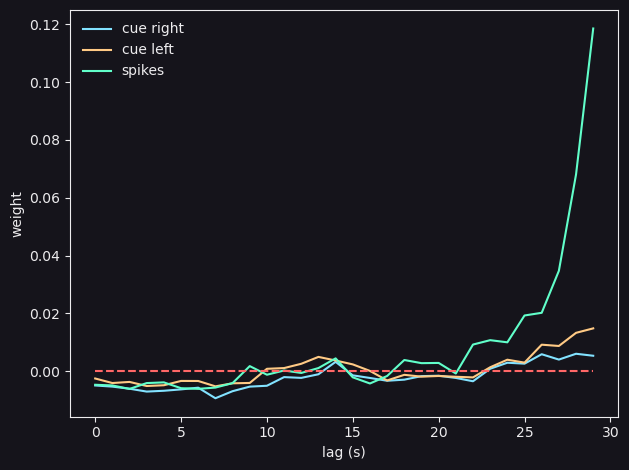

In [65]:
weights = np.zeros(y.shape[0]) * 0.0001
weights[:1000] = 1

glm = sm.GLM(endog=y, exog=X, family=sm.families.Poisson())#, freq_weights=weights)

# res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
alpha = 2 * np.ones(X.shape[1])
alpha[-1] = 0.01
res = glm.fit_regularized(alpha=alpha, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)
w = res.params
rate = np.exp(X@w)

LL = y.T @ np.log(rate) - rate.sum()
print(f"LL: {LL[0]}")

fig, ax = plt.subplots()
ax.plot(w[:(2*filt_len)].reshape(-1, filt_len).T, label=["cue right", "cue left"])
ax.plot(np.arange(filt_len)[-sp_filt_len:], w[(2*filt_len):-1], label='spikes')

# ax.plot(w[:-1].reshape(-1, filt_len).T, label=["cue right", "cue left"])

ax.plot(np.arange(filt_len), np.zeros(filt_len), "--")
ax.legend()
xlabels = np.round(
    -1 * np.arange(bin_size, filt_len * bin_size + bin_size, bin_size)[::-3], 1
)
# ax.set_xticks(np.arange(filt_len)[::2], xlabels)
ax.set_xlabel("lag (s)")
ax.set_ylabel("weight")
plt.tight_layout()


print(w[-1])

In [66]:
X_plot.shape

(22, 91)

290


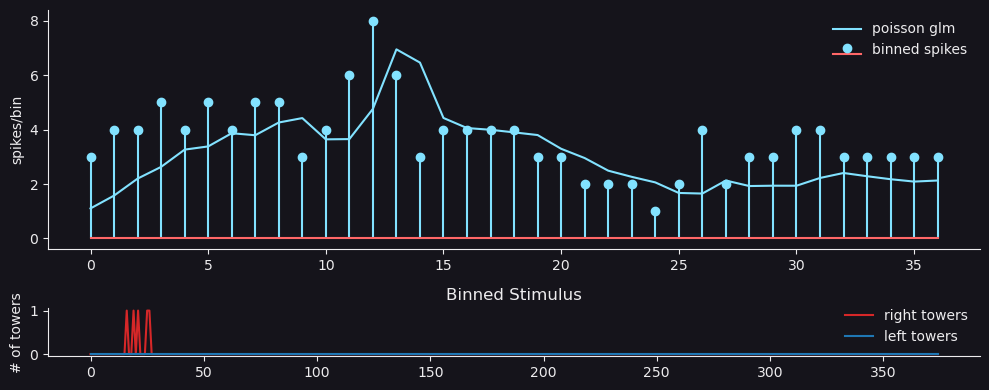

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})


sort_idx = np.argsort(data['nCues_RminusL'])  # ordered index of (lots of left cues) -> (lots of right cues)
plot_trial = 0
print(sort_idx.size)

X_plot = X[trial_id==plot_trial]
y_pred = np.exp(X_plot @ w)


y_plot = y[trial_id==plot_trial]
axs[0].stem(y_plot, label="binned spikes")
axs[0].plot(y_pred, label="poisson glm")
# trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel('spikes/bin')
axs[0].legend()


axs[1].plot(binned_stimr, color=colors[0], label="right towers")
axs[1].plot(binned_stiml, color=colors[1], label="left towers")
# trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[1].set_ylabel("# of towers")
axs[1].set_title("Binned Stimulus")
axs[1].legend()
plt.tight_layout()
sns.despine()

233


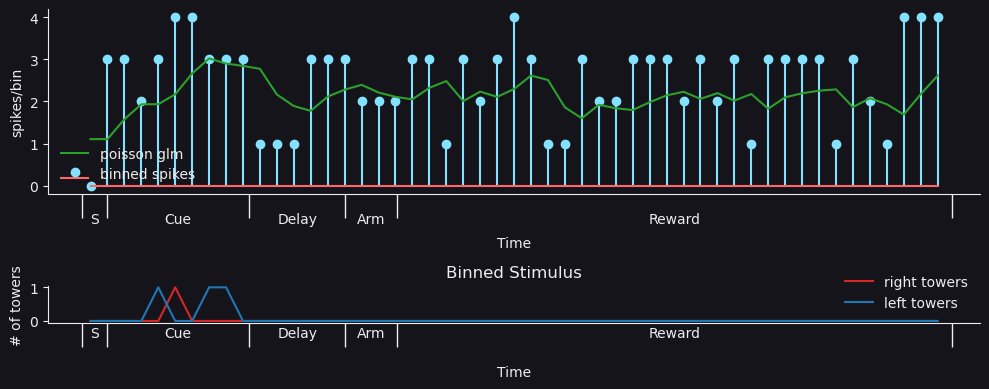

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})


sort_idx = np.argsort(data['nCues_RminusL'][data["currMaze"] > 7])  # ordered index of (lots of left cues) -> (lots of right cues)
plot_trial = sort_idx[100]
print(sort_idx.size)

trial_idx = np.nonzero(data["currMaze"] > 7)[0][plot_trial]
trial_start = data["trialStart"][trial_idx]
trial_end = data["trialEnd"][trial_idx]
trial_length = trial_end - trial_start
spikes = data["spikes"][neuron]
spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
keyframes = data["keyFrames"][trial_idx]
keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
lcue_times = data["cueOnset_L"][trial_idx]
rcue_times = data["cueOnset_R"][trial_idx]
bins = np.arange(0, trial_length, bin_size)
bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")
binned_stimr, _ = np.histogram(rcue_times, bins)
binned_stiml, _ = np.histogram(lcue_times, bins)
binned_spikes, _ = np.histogram(spikes - trial_start, bins)

padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])

padded_spikes = np.pad(binned_spikes[:-1], (sp_filt_len, 0), constant_values=(0, 0))
X_sp = hankel(padded_spikes[: -sp_filt_len + 1], padded_spikes[-sp_filt_len:])

X_plot = np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1))))
# X_plot = np.hstack((X_sr, X_sl, np.ones((X_sp.shape[0], 1))))

y_plot = binned_spikes[:, np.newaxis]
# y_pred = np.exp(pGLM_const + X_plot[:, :-1] @ pGLM_filt)
y_pred = np.exp(X_plot @ w)

axs[0].stem(bin_centers, y_plot, label="binned spikes")
axs[0].plot(bin_centers, y_pred, color="tab:green", label="poisson glm")
trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel('spikes/bin')
axs[0].legend()


axs[1].plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
axs[1].plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[1].set_ylabel("# of towers")
axs[1].set_title("Binned Stimulus")
axs[1].legend()
plt.tight_layout()
sns.despine()


<Axes: >

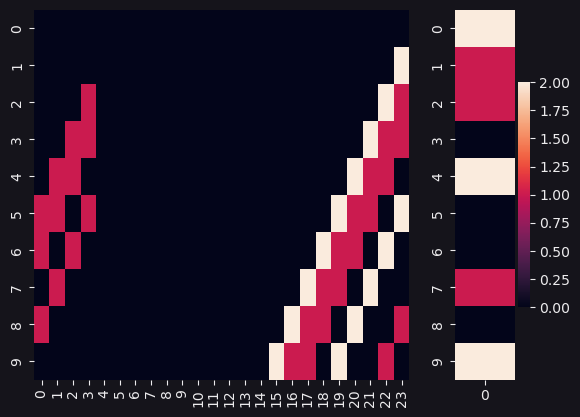

In [183]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]})
sns.heatmap(X[:10, -25:-1], ax=axs[0], cbar=False)
sns.heatmap(y[:10], ax=axs[1])

## Questions

- How should I pick bin size and filter length?
- How do I deal with trials in which I *should* delete them?
    - like trials with maze 7 or under. or trials in which the mouse turns around?
    - skip updating  but do predict at that step  don't delete from data
- It seems a little concerning to me that the weights are so noisy across time lags, I was expecting it to be smoother but it still seems to perform well.
- From initially looking at some of the neurons' GLM weights, I don't seem to be finding neurons which seem to have a left/right evidence preference? Is there a way to quantify it?
- I assume for the hmm, we assume that all neurons share the same state? Or do we assume they are all independent?
    - try both if possible. assuming same state more likely better but it would be cool if most neurons had the same state when run individually, or if we find clusters of neurons
- Any recommendations on how to fit GLM to each neuron more efficiently? Does multiprocessing in python work on the clusters? I initially gave it a try on scotty but it took way longer--not sure if it's bc scotty limits you to a single core or?
    - start with just like 10 neurons. ask ppl in the lab about multiprocessing
- Should we not look at start and reward period??

## To-do

- simulate some data with different glm weights and try to recover the different glm weights in each state
- try with and without spike history filter
- ~~smooth glm weights. check statsmodels to see if it can do this~~
- do psth divided up by evidence to see how well it predicts. also divide by evidence + choice
    - we probably have to time squeeze for this. but given the bin size we're using for the glm, this will most likely be upsampling??
- don't completely take out trials
- figure out which trials have turn arounds (may not be super important)
- try hmm with all neurons in the same state
- try hmm with all neurons having independent states